In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from nbdev import *

In [ ]:
#default_exp inference

In [ ]:
#export
import ijson
import pkg_resources
import pandas as pd
from cytoolz import itertoolz
from tqdm.auto import tqdm

from fastcore import *

In [ ]:
#export
from nnanno.core import *
from nnanno.sample import *

In [ ]:
#export
from typing import (
    Any,
    Optional,
    Union,
    Dict,
    List,
    Tuple,
    Set,
    Iterable,
)
from PIL import Image
import PIL

In [ ]:
#export 
import fastai
from fastai.vision.all import *
from fastcore import *

# Inference

This module contains some functionality for doing inference i.e. making predictions on new images from Newspaper Navigator. At the moment this functionality assumes that the model has been trained using [fastai](https://docs.fast.ai/). 

### Notes on inference

- iiif for inference
- load images for predictions in memory 
- returns the predictions metadata and urls for IIIF doesn't download the images themselves ThreadPoolExecutor

Since we are going to use fastai for inference we'll quickly create a model that we can use to test inference functionality. 

In [ ]:
dls = ImageDataLoaders.from_csv('../ph/ads/', 'ads_upsampled.csv',folder='images', fn_col='file', label_col='label',
                                item_tfms=Resize(64,ResizeMethod.Squish),num_workers=0)

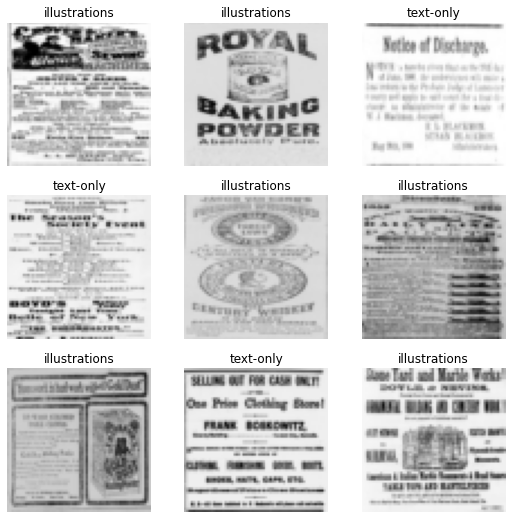

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=F1Score())
learn.fine_tune(1)

epoch,train_loss,valid_loss,f1_score,time
0,0.931389,0.669518,0.756410,00:06


epoch,train_loss,valid_loss,f1_score,time
0,0.479432,0.392866,0.797386,00:05


## Inference helpers 

The next few functions are 'helper' functions which are used for doing inference using the Newspaper Navigator data. 

### Missing images
Because we are dealing with images requested via the web we have to deal with the occasional hiccup. These hiccups could include requested image not being returned from an IIIF request, or a network issue etc. As a reminder of what `load_url_image` does

In [ ]:
doc(load_url_image)

load_url_image [source] load_url_image ( url : str , mode = 'RGB' ) 
 
 Attempts to load an image from url returns None if request times out or no image at url 
 Show in docs

As you can see above `load_url_image` will sometimes return `None`. When we're running inference this can cause an issue because we want to create batches of images to speed up inference. We don't want to include `None`s in a batch of images to predict since fastai/pytorch won't know what to do with it. 

To get around this we create a function which filters a batch of images and replaces `None` with a fake image. This function also returns the index of items which were originally `None`. We later use this index of items which were `None` to replace any predictions made for dummy images with `np.nan`

In [ ]:
#export
def _filter_replace_none_image(results:List[Optional[PIL.Image.Image]]):
    """
    filters a list containing images and `None`, replaces `None` with dummy images 
    returns: original images and dummy images + a location index for the dummy images
    """
    fakeim = Image.fromarray(244 * np.ones((250,250,3), np.uint8))
    results = L(results)
    none_image_index = results.argwhere(lambda x: x is None) # Gets the index for images which are none
    results[none_image_index] = fakeim # Replaces None with fakeim
    return results.items, none_image_index

We use this function to deal with `None`s appearing in our image batches before we pass them to a fastai learner. **Note** this could be a sub-optimal approach to this issue but since we don't encounter too many missing images and the overhead for this is fairly low it seems like an okay solution. 

In [ ]:
im_files = (get_image_files('../ph/ads/images'))[:8] 
results = list(map(PILImage.create,im_files))
results.append(None)
results = [None] + results
image_batch,none_image_index =_filter_replace_none_image(results)
assert len(results) == len(image_batch)
assert none_image_index.items == [0,9] # check indexes are at the start and end of list

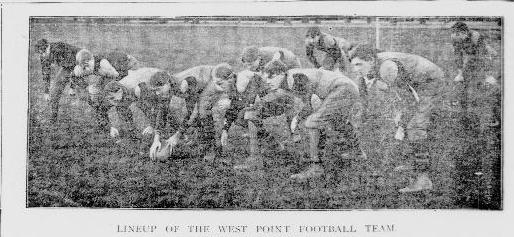

In [ ]:
#hide
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url);im

In [ ]:
#hide
im_files = (get_image_files('../ph/ads/images'))[:4]
images = list(map(PILImage.create, im_files))
results = [None] + images 
images,index =_filter_replace_none_image(results)

image_batch = [np.array(im) for im in images]
test_data = learn.dls.test_dl(image_batch)
pred_tuple = learn.get_preds(dl=test_data, with_decoded=True)
pred_decoded = L(pred_tuple[2], use_list=True)
pred_tensor =  L(pred_tuple[0],use_list=True)
pred_decoded[index] = np.nan; pred_tensor[index] = np.nan
pred_decoded.items, pred_tensor.items

([nan, tensor(1), tensor(0), tensor(1), tensor(1)],
 [nan,
  tensor([0.3105, 0.6895]),
  tensor([9.9939e-01, 6.0675e-04]),
  tensor([0.2570, 0.7430]),
  tensor([0.1224, 0.8776])])

In [ ]:
#hide
url = 'https://news-navigator.labs.loc.gov/data/dlc_fiji_ver01/data/sn83030214/00175040936/1900102801/0519/001_0_99.jpg'
im = load_url_image(url)
images = [im,im,im]
results = [None] + images 
images,index =_filter_replace_none_image(results)
image_batch = [np.array(im) for im in images]
list(map(np.shape,image_batch))

[(250, 250, 3), (237, 514, 3), (237, 514, 3), (237, 514, 3)]

In [ ]:
#exporti
def _create_pred_header(fname, dls=None):
    columns=[
            "filepath",
            "pub_date",
            "page_seq_num",
            "edition_seq_num",
            "batch",
            "lccn",
            "box",
            "score",
            "ocr",
            "place_of_publication",
            "geographic_coverage",
            "name",
            "publisher",
            "url",
            "page_url",
            "iiif_url",
            "pred_decoded"]
    if dls:
        columns += (list(dls.vocab))
    return pd.DataFrame(columns=columns).to_csv(fname, index=None)

In [ ]:
#hide
_create_pred_header('test_header.csv')
df = pd.read_csv('test_header.csv')
assert df.columns.to_list() == ['filepath', 'pub_date', 'page_seq_num', 'edition_seq_num', 'batch',
       'lccn', 'box', 'score', 'ocr', 'place_of_publication',
       'geographic_coverage', 'name', 'publisher', 'url', 'page_url',
       'iiif_url', 'pred_decoded']
Path('test_header.csv').unlink()
_create_pred_header('test_header.csv', dls=dls)
df = pd.read_csv('test_header.csv')
assert len(df[dls.vocab].columns) == dls.c
Path('test_header.csv').unlink()

In [ ]:
#exporti
def _create_year_csv(out_dir, year,kind,dls=None):
    fname = Path(f"{out_dir}/{year}_{kind}.csv")
    _create_pred_header(fname, dls)
    return fname

In [ ]:
#exporti
def _create_year_json(out_dir, year,kind, batch):
    return Path(f"{out_dir}/{year}_{kind}_{batch}.json")

In [ ]:
#hide
Path('test_csv').mkdir()
_create_year_csv('test_csv',1850,'ads')
assert Path('test_csv/1850_ads.csv').exists() == True
Path('test_csv/1850_ads.csv').unlink();Path('test_csv/').rmdir()

In [ ]:
#exporti
def _make_directory(directory, force=False):
    if not force:
        if Path(directory).exists() and len(list(os.scandir(directory))) >=1:
            raise ValueError(f'{directory} already exists and is not empty')
    Path(directory).mkdir(exist_ok=True,parents=True)   

In [ ]:
#hide
_make_directory('test_dir')
assert Path('test_dir/').exists() ; Path('test_dir/test.file').touch()
with ExceptionExpected(ex=ValueError, regex="test_dir already exists and is not empty"): 
    _make_directory('test_dir')
Path('test_dir/test.file').unlink(); Path('test_dir').rmdir()

## Predict

In [ ]:
#hide
# TODO how to save to json 

# TODO save to csv a bit more nicely 

In [ ]:
#export
# TODO tidy class and refactor
class nnPredict:
    """`nnPredict` is used in combination with a trained leaner to run inference on Newspaper Navigator"""
    population = pd.read_csv(pkg_resources.resource_stream('nnanno', 'data/all_year_counts.csv'),
                                      index_col=0)
    def __init__(self, learner:fastai.learner, try_gpu:bool=True):
        """Creates an ``nnPredict` instance from `learner`, puts on GPU if `try_gpu` is true and CUDA is avilable"""
        self.learner = learner
        self.try_gpu = try_gpu
        self.dls = learner.dls
    
    def __repr__(self):
        return (f'{self.__class__.__name__} \n'
               f'learner vocab:{self.learner.dls.vocab}')      
    
    @classmethod
    def _get_year_population_size(cls, kind:str,year:Union[str,int]):
        return cls.population[f"{kind}_count"][year]
    
    @classmethod
    def _get_year_sample_size(cls, kind:str, year:Union[str,int], sample_size):
        return (cls._get_year_population_size(kind, year) * sample_size).clip(1).round()

    def predict_from_sample_df(self, sample_df:pd.DataFrame,bs:int=16,
                               disable_pro:bool=False) -> pd.DataFrame:
        """
        Runs inference on `sample_df` using batch size `bs`.
        returns a Pandas DataFrame containing orginal dataframe and predictions, with labels taken from `learner.dls.vocab`
        """
        self.sample_df = sample_df 
        gpu = False
        if self.try_gpu and torch.cuda.is_available():
            gpu = True
        if gpu:
            self.learner.model = self.learner.model.cuda()
        
        self.sample_df['iiif_url'] = self.sample_df.apply(lambda x: iiif_df_apply(x), axis=1)
        dfs = []
        
        splits = max(1,round(len(self.sample_df)/bs))
        for df in tqdm(np.array_split(sample_df, splits),
                       disable=disable_pro,
                       leave=False,
                       desc='Batch progress'):
            futures = []
            for url in df['iiif_url'].to_list():
                with concurrent.futures.ThreadPoolExecutor(get_max_workers(df)) as e:
                    future = e.submit(load_url_image, url)
                    futures.append(future)
            results = [future.result() for future in futures]
            image_list, none_index = _filter_replace_none_image(results)
            im_as_arrays = [np.array(image) for image in image_list]
           # if len(none_index) >0:
            #            tqdm.write(f"{none_index} skipped")
            test_data = self.learner.dls.test_dl(im_as_arrays)
            if gpu:
                test_data.to('cuda')
            with self.learner.no_bar():
                pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
            pred_decoded = L(pred_tuple[2], use_list=True)
            pred_tensor =  L(pred_tuple[0],use_list=None)
            pred_decoded[none_index] = np.nan
            pred_tensor[none_index] = np.nan
            df["pred_decoded"] = pred_decoded.items
            df["pred_decoded"] = df['pred_decoded'].astype(float)
            # create an empty df column for each class in dls.vocab
            for c in self.dls.vocab:
                df[f'{c}_prob'] = ''
            # append the tensor predictions to the last `c` colomns of the df
            df.iloc[:,-self.dls.c:] = np.hsplit(pred_tensor.items.numpy(), self.dls.c) #split into columns
           # if save:
               # df.to_csv('test.csv', header=None, index=None, mode="a")
            dfs.append(df)
        return pd.concat(dfs)

    def predict_sample(self,
        kind: str,
        out_dir: str,
        sample_size: Union[int, float],
        bs: int = 16,
        start_year: int = 1850,
        end_year: int = 1950,
        step: int = 1,
        year_sample:bool=True,
        size=None,
        return_df:bool = False,
        force_dir=False):
        
        _make_directory(out_dir,force_dir)
        years = range(start_year, end_year + 1, step)
        if type(sample_size) == float:
            total = int(self._get_year_sample_size(kind,list(years),sample_size).sum())
        if type(sample_size) == int:
            total = sample_size * len(years)
        dfs = []
        with tqdm(total=total) as pbar:
            for year in years:
                pbar.set_description(f"Predicting: {year}, total progress")
                #if type(sample_size) == float:
                #    sample_size = int(self._get_year_sample_size(kind,year,sample_size))
                sample = sample_year(kind, sample_size, year)
                sample_df = pd.DataFrame.from_records(sample)
                disable_pro = False
                if len(sample_df) <= 2:
                    disable_pro = True
                pred_df = self.predict_from_sample_df(sample_df, bs, disable_pro=disable_pro)
                pred_df.to_json(f'{out_dir}/{year}.json') # TODO make sure this file is created before attempting to save
                pbar.update(len(pred_df))

    def predict(
        self,
        kind: str,
        out_dir: str,
        bs: int = 32,
        start_year: int = 1850,
        end_year: int = 1950,
        step: int = 1,
        size=None
    ):
        _make_directory(out_dir)
        gpu = False
        if self.try_gpu and torch.cuda.is_available():
            gpu = True
        if gpu:
            self.learner.model = self.learner.model.cuda()
        years = range(start_year, end_year + 1, step)
        total = self._get_year_population_size(kind,years).sum()
        with tqdm(total=total) as pbar:
            for year in years:
                out_fn = _create_year_csv(out_dir,year,kind, self.learner.dls)
                pbar.set_description(f"Predicting: {year}, total progress")
                if kind == ('ads' and int(year) >=1870) or (kind == 'headlines'):
                    s = create_session()
                else:
                    s = create_cached_session()
                with s.get(get_json_url(year, kind), timeout=60) as r:
                    data = ijson.items(r.content, "item")
                    batches = itertoolz.partition_all(bs, iter(data))
                    year_total = self._get_year_population_size(kind,year)
                    if (year_total//bs) <= 1:
                        disable_p_bar = True
                    for i, batch in enumerate(tqdm(batches,total=round(year_total//bs),
                                                   leave=False,
                                                   desc='Batch Progress')):
                        df = pd.DataFrame(batch)
                        df["iiif_url"] = df.apply(lambda x: iiif_df_apply(x), axis=1)
                        futures = []
                        workers = get_max_workers(df)
                        for iif_url in df["iiif_url"].values:
                            with concurrent.futures.ThreadPoolExecutorolExecutor(workers) as e:
                                future = e.submit(load_url_image, iif_url)
                                futures.append(future)
                        results = [future.result() for future in futures]
                        image_list, none_index = _filter_replace_none_image(results)
                        im_as_arrays = [np.array(image) for image in image_list]
                        if len(none_index) >0:
                            tqdm.write(f"{none_index} skipped")
                        else:
                            pass
                        test_data = self.learner.dls.test_dl(im_as_arrays)
                        with self.learner.no_bar():
                            pred_tuple = self.learner.get_preds(dl=test_data, with_decoded=True)
                        pred_decoded = L(pred_tuple[2], use_list=True)
                        pred_tensor =  L(pred_tuple[0],use_list=None)
                        pred_decoded[none_index] = np.nan
                        pred_tensor[none_index] = np.nan
                        df["pred_decoded"] = pred_decoded.items
                        df["pred_decoded"] = df['pred_decoded'].astype(float)
                        # create an empty df column for each class in dls.vocab
                        for c in self.dls.vocab:
                            df[f'{c}_prob'] = ''
                        # append the tensor predictions to the last `c` columns of the df
                        df.iloc[:,-self.dls.c:] = np.hsplit(pred_tensor.numpy(),self.dls.c) #split into columns
                        df.to_csv(out_fn, header=None, index=None, mode="a")
                        pbar.update(bs)

In [ ]:
pred = nnPredict(learn)

In [ ]:
#pred.predict_sample('ads','testspeed/',0.001,start_year=1850, end_year=1852, bs=32,force_dir=True)

In [ ]:
show_doc(nnPredict.predict_sample)

<h4 id="nnPredict.predict_sample" class="doc_header"><code>nnPredict.predict_sample</code><a href="__main__.py#L77" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_sample</code>(**`kind`**:`str`, **`out_dir`**:`str`, **`sample_size`**:`Union`\[`int`, `float`\], **`bs`**:`int`=*`16`*, **`start_year`**:`int`=*`1850`*, **`end_year`**:`int`=*`1950`*, **`step`**:`int`=*`1`*, **`year_sample`**:`bool`=*`True`*, **`size`**=*`None`*, **`return_df`**:`bool`=*`False`*, **`force_dir`**=*`False`*)



Newspaper Navigator can get quit big, for particular classes of visual content and certain years. Just as you may sample to create annotations if you are running inference you may also want to do this on a sample of the full data. The `predict_sample` method will run inference across a given type of image `kind`, creating a `sample_size` for each year between `start_year` and `end_year` for step size `step`.

`sample_size` can either be an int i.e. 100 predictions for each year, or it can be a float representing a percentage to sample from each year i.e. 10% from each year. 

### Limitations 
Currently `predict_sample` assumes that the size of each years sample can fit into memory. 


In [ ]:
#hide_input
show_doc(nnPredict.predict_from_sample_df)

<h4 id="nnPredict.predict_from_sample_df" class="doc_header"><code>nnPredict.predict_from_sample_df</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict_from_sample_df</code>(**`sample_df`**:`DataFrame`, **`bs`**:`int`=*`16`*, **`disable_pro`**:`bool`=*`False`*)

Runs inference on `sample_df` using batch size `bs`.
returns a Pandas DataFrame containing orginal dataframe and predictions, with labels taken from `learner.dls.vocab`

In [ ]:
show_doc(nnPredict.predict)

<h4 id="nnPredict.predict" class="doc_header"><code>nnPredict.predict</code><a href="__main__.py#L111" class="source_link" style="float:right">[source]</a></h4>

> <code>nnPredict.predict</code>(**`kind`**:`str`, **`out_dir`**:`str`, **`bs`**:`int`=*`32`*, **`start_year`**:`int`=*`1850`*, **`end_year`**:`int`=*`1950`*, **`step`**:`int`=*`1`*, **`size`**=*`None`*)



In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_sample.ipynb.
Converted 02_annotate.ipynb.
Converted 03_inference.ipynb.
Converted index.ipynb.
